<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Random Forest (RF) Modeling 
</p>

In [1]:
# Libraries for data manipulation and visualization
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and evaluation
from sklearn.ensemble import RandomForestRegressor  # For Random Forest Regression
from sklearn.metrics import (                     # For model evaluation metrics
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)
from sklearn.model_selection import (              # For cross-validation, splitting data, and grid search
    KFold, 
    train_test_split, 
    GridSearchCV
)

# Set seed for reproducibility
np.random.seed(50)

In [2]:
# Define the path to the dataset
dataset_path = '../../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    import sys
    sys.exit()

# Display dataset information
print("\nDataset Information:")
df.info()
print("\nFirst Five Rows of the Dataset:")
display(df.head())

Dataset loaded successfully.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749214 entries, 0 to 749213
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         749214 non-null  object 
 1   device_id    749214 non-null  object 
 2   co2          749214 non-null  float64
 3   humidity     749214 non-null  float64
 4   pm25         749214 non-null  float64
 5   pressure     749214 non-null  float64
 6   temperature  749214 non-null  float64
 7   rssi         749214 non-null  float64
 8   snr          749214 non-null  float64
 9   SF           749214 non-null  int64  
 10  frequency    749214 non-null  float64
 11  f_count      749214 non-null  float64
 12  p_count      749214 non-null  float64
 13  toa          749214 non-null  float64
 14  distance     749214 non-null  int64  
 15  c_walls      749214 non-null  int64  
 16  w_walls      749214 non-null  int64  
 17  exp_pl       749

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:00:52.542462+00:00,ED3,633.0,54.22,0.58,300.41,23.85,-71.0,12.2,10,867.9,94.0,104.0,0.452608,18,1,2,88.4,-83.454107,-71.254107
1,2024-09-26 11:01:52.383162+00:00,ED3,645.0,54.18,0.32,300.48,23.87,-74.0,12.5,9,867.7,95.0,105.0,0.246784,18,1,2,91.4,-86.737602,-74.237602
2,2024-09-26 11:02:52.425491+00:00,ED3,648.0,54.23,0.58,300.50,23.88,-76.0,12.2,9,867.1,96.0,106.0,0.246784,18,1,2,93.4,-88.454107,-76.254107
3,2024-09-26 11:02:52.426016+00:00,ED3,648.0,54.23,0.58,300.50,23.88,-76.0,12.2,9,867.1,96.0,106.0,0.246784,18,1,2,93.4,-88.454107,-76.254107
4,2024-09-26 11:03:52.481201+00:00,ED3,645.0,54.25,0.33,300.50,23.90,-76.0,13.2,9,868.3,97.0,107.0,0.246784,18,1,2,93.4,-89.403045,-76.203045


In [3]:
# Define feature columns and target
feature_columns = [
    'distance', 'frequency', 'c_walls', 'w_walls', 
    'co2', 'humidity', 'pm25', 'pressure', 
    'temperature', 'snr'
]
target_column = 'exp_pl'

# Verify that all required columns exist
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and target
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Perform train-test split (80-20 split)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, PL_all, test_size=0.2, random_state=50
)

print("Train-test split completed.")

Train-test split completed.


In [4]:
# Define the fixed max_depth values
max_depth_values = [1, 2, 3]

# Define other hyperparameters for grid search
param_grid = {
    'n_estimators': [100, 200, 300],            # Number of trees in the forest
    'min_samples_split': [2, 10, 100],         # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]              # Minimum samples required at a leaf node
}

# Dictionary to store the best models for each max_depth
best_models = {}
best_params_per_depth = {}
best_scores_per_depth = {}

# Iterate over each max_depth and perform grid search
for depth in max_depth_values:
    print(f"\nPerforming Grid Search for max_depth={depth}...")
    
    # Create a base Random Forest Regressor with the current max_depth
    rf = RandomForestRegressor(
        max_depth=depth,
        criterion='squared_error',                # Fixed criterion
        max_features='log2',                      # Fixed max_features
        min_impurity_decrease=0.001,              # Fixed min_impurity_decrease
        random_state=50, 
        n_jobs=-1, 
        bootstrap=True, 
        oob_score=True
    )
    
    # Initialize Grid Search
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,                                       # 5-fold cross-validation
        scoring='neg_mean_squared_error',           # Using negative MSE for comparison
        verbose=1,
        n_jobs=-1
    )
    
    # Perform Grid Search
    grid_search.fit(X_train_all, PL_train_all)
    
    # Retrieve the best parameters and corresponding score
    best_params = grid_search.best_params_
    best_neg_mse = grid_search.best_score_
    best_mse = -best_neg_mse  # Convert from negative MSE to MSE
    
    best_models[depth] = grid_search.best_estimator_
    best_params_per_depth[depth] = best_params
    best_scores_per_depth[depth] = best_mse
    
    print(f"Best Parameters for max_depth={depth}: {best_params}")
    print(f"Best CV MSE for max_depth={depth}: {best_mse:.4f}")


Performing Grid Search for max_depth=1...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for max_depth=1: {'min_samples_leaf': 1, 'min_samples_split': 100, 'n_estimators': 100}
Best CV MSE for max_depth=1: 155.5505

Performing Grid Search for max_depth=2...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for max_depth=2: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV MSE for max_depth=2: 85.1303

Performing Grid Search for max_depth=3...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for max_depth=3: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best CV MSE for max_depth=3: 55.8393


In [5]:
# Initialize a list to store evaluation metrics for each model
evaluation_metrics = []

for depth in max_depth_values:
    model = best_models[depth]
    params = best_params_per_depth[depth]
    
    print(f"\nEvaluating model with max_depth={depth} and parameters: {params}")
    
    # Train the model on the entire training set
    model.fit(X_train_all, PL_train_all)
    
    # Retrieve OOB score
    oob_score = model.oob_score_
    
    # Make predictions
    PL_train_pred = model.predict(X_train_all)
    PL_test_pred = model.predict(X_test_all)
    
    # Calculate metrics
    train_mse = mean_squared_error(PL_train_all, PL_train_pred)
    test_mse = mean_squared_error(PL_test_all, PL_test_pred)
    train_r2 = r2_score(PL_train_all, PL_train_pred)
    test_r2 = r2_score(PL_test_all, PL_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mape = mean_absolute_percentage_error(PL_test_all, PL_test_pred)
    test_median_ae = median_absolute_error(PL_test_all, PL_test_pred)
    
    # Append metrics to the list
    evaluation_metrics.append({
        'max_depth': depth,
        'OOB Score': oob_score,
        'Training Loss (MSE)': train_mse,
        'Test Loss (MSE)': test_mse,
        'Test RMSE': test_rmse,
        'R² Score': test_r2,
        'Test MAPE (%)': test_mape * 100,
        'Test Median AE': test_median_ae
    })
    
    print(f"Model with max_depth={depth} - OOB Score: {oob_score:.4f}")
    print(f"Training MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAPE: {test_mape*100:.2f}%, Test Median AE: {test_median_ae:.4f}")
    
# Create a results DataFrame
results_df = pd.DataFrame(evaluation_metrics)

print("\nModel Evaluation Metrics for Best Models per max_depth:")
display(results_df)


Evaluating model with max_depth=1 and parameters: {'min_samples_leaf': 1, 'min_samples_split': 100, 'n_estimators': 100}
Model with max_depth=1 - OOB Score: 0.5596
Training MSE: 155.5440, Test MSE: 155.1830
Training R²: 0.5623, Test R²: 0.5635
Test RMSE: 12.4572, Test MAPE: 10.91%, Test Median AE: 8.4787

Evaluating model with max_depth=2 and parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Model with max_depth=2 - OOB Score: 0.7577
Training MSE: 85.1301, Test MSE: 84.8789
Training R²: 0.7605, Test R²: 0.7613
Test RMSE: 9.2130, Test MAPE: 7.54%, Test Median AE: 5.6399

Evaluating model with max_depth=3 and parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Model with max_depth=3 - OOB Score: 0.8419
Training MSE: 55.9139, Test MSE: 55.6928
Training R²: 0.8427, Test R²: 0.8434
Test RMSE: 7.4628, Test MAPE: 6.16%, Test Median AE: 4.6115

Model Evaluation Metrics for Best Models per max_depth:


,max_depth,OOB Score,Training Loss (MSE),Test Loss (MSE),Test RMSE,R² Score,Test MAPE (%),Test Median AE
0,1,0.559588,155.544018,155.182985,12.457246,0.563537,10.912029,8.478684
1,2,0.757732,85.130114,84.878852,9.212972,0.761272,7.538428,5.639916
2,3,0.841887,55.913944,55.692813,7.462762,0.843360,6.157181,4.611486


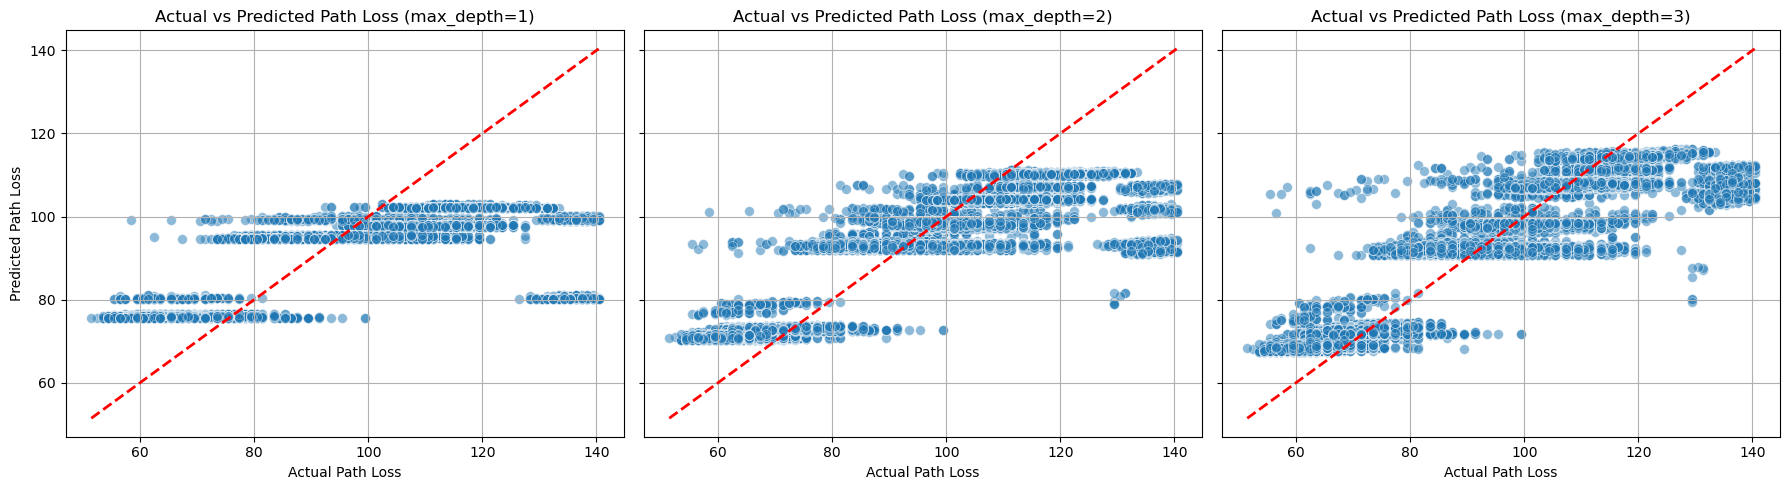

In [6]:
# Number of models
num_models = len(max_depth_values)

# Set up the subplot grid (1 row, 3 columns)
fig, axes = plt.subplots(1, num_models, figsize=(18, 5), sharey=True)

# If only one subplot, make axes iterable
if num_models == 1:
    axes = [axes]

for ax, depth in zip(axes, max_depth_values):
    model = best_models[depth]
    PL_test_pred = model.predict(X_test_all)
    
    sns.scatterplot(x=PL_test_all, y=PL_test_pred, alpha=0.5, edgecolor='w', s=50, ax=ax)
    ax.plot([PL_test_all.min(), PL_test_all.max()], [PL_test_all.min(), PL_test_all.max()], 'r--', lw=2)
    ax.set_xlabel('Actual Path Loss')
    ax.set_ylabel('Predicted Path Loss')
    ax.set_title(f'Actual vs Predicted Path Loss (max_depth={depth})')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Define the number of folds for cross-validation
n_folds = 5

# Initialize KFold
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Dictionary to store cross-validation results
cv_results_dict = {depth: [] for depth in max_depth_values}

print("\nPerforming K-Fold Cross-Validation for Each Best Model...\n")

for depth in max_depth_values:
    model = best_models[depth]
    params = best_params_per_depth[depth]
    
    print(f"Cross-Validation for max_depth={depth} with parameters: {params}")
    
    fold = 1
    for train_idx, val_idx in kf.split(X_train_all):
        print(f"  Training fold {fold}...")
        
        # Split the data for the current fold
        X_train_fold, X_val_fold = X_train_all[train_idx], X_train_all[val_idx]
        PL_train_fold, PL_val_fold = PL_train_all[train_idx], PL_train_all[val_idx]
        
        # Instantiate a new model with the best parameters
        rf_cv = RandomForestRegressor(
            max_depth=depth,
            criterion='squared_error',                # Fixed criterion
            max_features='log2',                      # Fixed max_features
            min_impurity_decrease=0.001,              # Fixed min_impurity_decrease
            n_estimators=params['n_estimators'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=50, 
            n_jobs=-1, 
            bootstrap=True, 
            oob_score=True
        )
        
        # Train the model on the current fold
        rf_cv.fit(X_train_fold, PL_train_fold)
        
        # Predict on validation set
        PL_val_pred = rf_cv.predict(X_val_fold)
        
        # Calculate metrics
        val_mse = mean_squared_error(PL_val_fold, PL_val_pred)
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(PL_val_fold, PL_val_pred)
        val_mape = mean_absolute_percentage_error(PL_val_fold, PL_val_pred)
        val_median_ae = median_absolute_error(PL_val_fold, PL_val_pred)
        
        # Append metrics to the dictionary
        cv_results_dict[depth].append({
            'Fold': fold,
            'Validation Loss (MSE)': round(val_mse, 4),
            'Validation RMSE': round(val_rmse, 4),
            'R² Score': round(val_r2, 4),
            'Validation MAPE (%)': round(val_mape * 100, 2),
            'Validation Median AE': round(val_median_ae, 4)
        })
        
        print(f"    Fold {fold} - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, MAPE: {val_mape*100:.2f}%, Median AE: {val_median_ae:.4f}\n")
        fold += 1

# Create a DataFrame for each max_depth's CV results and display them
for depth in max_depth_values:
    print(f"\nK-Fold Cross-Validation Results for max_depth={depth}:")
    cv_results_df = pd.DataFrame(cv_results_dict[depth])
    display(cv_results_df)
    
    # Summary statistics
    cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
    cv_summary.rename(columns={'index': 'Metric'}, inplace=True)
    print(f"\nCross-Validation Summary for max_depth={depth}:")
    display(cv_summary)


Performing K-Fold Cross-Validation for Each Best Model...

Cross-Validation for max_depth=1 with parameters: {'min_samples_leaf': 1, 'min_samples_split': 100, 'n_estimators': 100}
  Training fold 1...
    Fold 1 - MSE: 155.5884, RMSE: 12.4735, R²: 0.5611, MAPE: 10.88%, Median AE: 8.4641

  Training fold 2...
    Fold 2 - MSE: 156.1509, RMSE: 12.4960, R²: 0.5613, MAPE: 10.89%, Median AE: 8.4727

  Training fold 3...
    Fold 3 - MSE: 154.6669, RMSE: 12.4365, R²: 0.5640, MAPE: 10.87%, Median AE: 8.4596

  Training fold 4...
    Fold 4 - MSE: 155.1270, RMSE: 12.4550, R²: 0.5644, MAPE: 10.93%, Median AE: 8.4805

  Training fold 5...
    Fold 5 - MSE: 156.0912, RMSE: 12.4936, R²: 0.5611, MAPE: 10.87%, Median AE: 8.4304

Cross-Validation for max_depth=2 with parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Training fold 1...
    Fold 1 - MSE: 85.0712, RMSE: 9.2234, R²: 0.7600, MAPE: 7.51%, Median AE: 5.6037

  Training fold 2...
    Fold 2 - MSE: 85.5892, R

,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,1,155.5884,12.4735,0.5611,10.88,8.4641
1,2,156.1509,12.4960,0.5613,10.89,8.4727
2,3,154.6669,12.4365,0.5640,10.87,8.4596
3,4,155.1270,12.4550,0.5644,10.93,8.4805
4,5,156.0912,12.4936,0.5611,10.87,8.4304



Cross-Validation Summary for max_depth=1:


,Metric,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,mean,3.0000,155.5249,12.4709,0.5624,10.8880,8.4615
1,std,1.5811,0.6346,0.0254,0.0017,0.0249,0.0191



K-Fold Cross-Validation Results for max_depth=2:


,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,1,85.0712,9.2234,0.7600,7.51,5.6037
1,2,85.5892,9.2514,0.7595,7.53,5.6193
2,3,84.3221,9.1827,0.7623,7.49,5.5957
3,4,84.9093,9.2146,0.7616,7.55,5.6233
4,5,85.7686,9.2611,0.7588,7.52,5.5824



Cross-Validation Summary for max_depth=2:


,Metric,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,mean,3.0000,85.1321,9.2266,0.7604,7.5200,5.6049
1,std,1.5811,0.5752,0.0312,0.0015,0.0224,0.0169



K-Fold Cross-Validation Results for max_depth=3:


,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,1,55.6681,7.4611,0.8430,6.12,4.5728
1,2,56.1898,7.4960,0.8421,6.14,4.5773
2,3,55.3204,7.4378,0.8441,6.11,4.5587
3,4,55.8101,7.4706,0.8433,6.16,4.5740
4,5,56.1696,7.4946,0.8421,6.13,4.5409



Cross-Validation Summary for max_depth=3:


,Metric,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,mean,3.0000,55.8316,7.4720,0.8429,6.1320,4.5647
1,std,1.5811,0.3644,0.0244,0.0008,0.0192,0.0151
